### Get the Environment Ready

In [1]:
from IPython.core.display import clear_output
!wget https://raw.githubusercontent.com/rahulrajpr/references/main/requirements_tf_cert_exam.txt
clear_output()

In [2]:
!wget https://raw.githubusercontent.com/rahulrajpr/references/main/helper_functions.py
clear_output()

In [3]:
!pip install -r requirements_tf_cert_exam.txt
!pip install split_folders
clear_output()

In [4]:
!python -V

Python 3.9.16


> Lets import the libraries

In [5]:
import os
import random
import pandas as pd
import numpy as np
import scipy
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
import string

In [6]:
print(f'tensorflow version : {tf.__version__}')
print(f'pandas version : {pd.__version__}')
print(f'numpy version : {np.__version__}')
print(f'scipy version : {scipy.__version__}')

tensorflow version : 2.10.0
pandas version : 1.4.2
numpy version : 1.22.4
scipy version : 1.7.3


### Download the DataSet

- "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

In [7]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2023-03-30 07:34:52--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  77.4MB/s    in 1.0s    

2023-03-30 07:34:53 (77.4 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



> Untar the Data

In [8]:
from helper_functions import unzip_untar_data
unzip_untar_data('/content/aclImdb_v1.tar.gz')

File extension : .tar.gz
File extracting.......
Completed successfully


> Check the available directories

In [9]:
[x for x in os.listdir() if x.find('.') < 0]

['aclImdb', '__pycache__', 'sample_data']

In [10]:
[x for x in os.listdir('aclImdb') if x.find('.') < 0]

['README', 'test', 'train']

In [11]:
[x for x in os.listdir('aclImdb/train') if x.find('.') < 0]

['neg', 'pos', 'unsup']

The folder we wanted are 

- train/pos
- train/neg

### Load the Dataset from the directory into lists

In [12]:
from helper_functions import read_text_file_classes

In [13]:
sentences, labels = read_text_file_classes(dir = 'aclImdb/train', classes = ['pos', 'neg'])

reading <.txt> files in t: aclImdb/train/pos
reading <.txt> files in t: aclImdb/train/neg

features found : 25000
lables found : 2

classes : ['neg' 'pos']
balance : [0.5 0.5]


In [14]:
sentences[:3], labels[:3]

(["This may sound crazy to even the people who remember this show...But I remembered this as being live-action. I don't think I ever saw the cartoon. but movie? maybe. I remember it very clearly. The guy was in a building kinda like a showroom. He even had the red jacket. It was dark out and he turned into a red car and there was this guy on the second level looking down at him. The car/guy spun around and crashed through the big showroom type window and out onto the street. And then proceeded to drive off. That is all I remember. I really hope someone else out there remembers this too. If not, Maybe I'm still crazy. But I'm hoping I'm not.",
  'Call me stupid, but I absolutely loved the 2001 horror movie, Valentine. It was so well-made, well-written, well-acted, well-directed, etc! Everything about it was wonderful! There were parts that were relatively routine (Lily\'s death), very funny (www.Bleed-Me-Dry.com), completely horrifying and creepy (Paige\'s death), and just plain heartbr

> Lets check the balance of the dataset

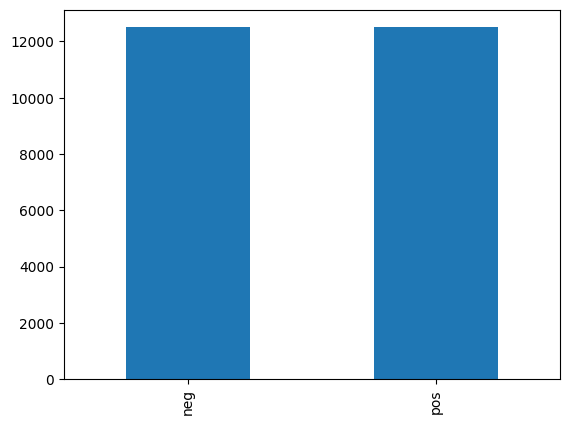

In [15]:
pd.Series(labels).value_counts().plot(kind = 'bar');

> lets encode the label

In [16]:
labels = [1 if x == 'pos' else 0 for x in labels]
labels[:10]

[0, 1, 1, 0, 1, 1, 0, 1, 0, 1]

### Split the train and validations sets

In [17]:
train_ratio = 0.8
train_size = int(len(sentences)*train_ratio)

In [18]:
train_sentenses, train_labels = sentences[:train_size], labels[:train_size]
val_sentences, val_labels = sentences[train_size:],labels[train_size:]

len(train_sentenses), len(train_labels),len(val_sentences), len(val_labels)

(20000, 20000, 5000, 5000)

> Recheck the balance of class in the trian data

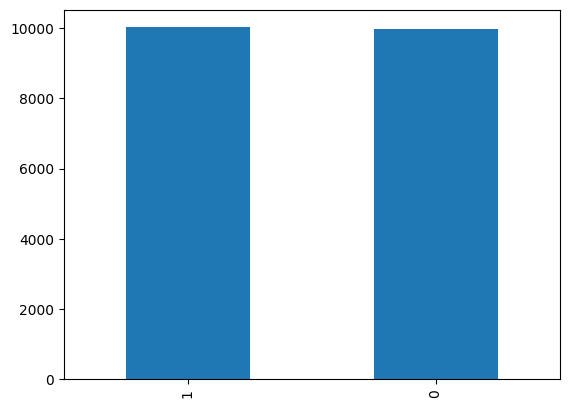

In [19]:
pd.Series(train_labels).value_counts().plot(kind = 'bar');

### Standardize the text

In [20]:
import string
def custom_standardization(text):
    x = tf.strings.lower(text) # conver all the text into lowercase
    x = tf.strings.regex_replace(x, '<[^>]*>', '') # replace the html tags with nothing
    x = tf.strings.regex_replace(x, '[' + string.punctuation + ']', '') # replace the punctuations with nothing
    x = x.numpy().decode('utf-8') # convert into a numpy value and decaode the test into utf-8 format
    return x

In [21]:
train_sentences = [custom_standardization(x) for x in train_sentenses]
val_sentences = [custom_standardization(x) for x in val_sentences]

In [22]:
train_sentences[:2]

['this may sound crazy to even the people who remember this showbut i remembered this as being liveaction i dont think i ever saw the cartoon but movie maybe i remember it very clearly the guy was in a building kinda like a showroom he even had the red jacket it was dark out and he turned into a red car and there was this guy on the second level looking down at him the carguy spun around and crashed through the big showroom type window and out onto the street and then proceeded to drive off that is all i remember i really hope someone else out there remembers this too if not maybe im still crazy but im hoping im not',
 'call me stupid but i absolutely loved the 2001 horror movie valentine it was so wellmade wellwritten wellacted welldirected etc everything about it was wonderful there were parts that were relatively routine lilys death very funny wwwbleedmedrycom completely horrifying and creepy paiges death and just plain heartbreaking the first scene i think the entire cast did a gre

### Define the Gloabl Variables

In [23]:
BATCH_SIZE = 32

VOCAB_SIZE = 10000
OOV_TOKEN = '<OOV>'

EMBED_LEN = 16
PADDING_LEN = 124

PADDING_STYLE = 'post'
TRUNC_STYLE = 'post'

### Tokenize & Pad the Text

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token = OOV_TOKEN)

In [26]:
tokenizer.fit_on_texts(train_sentences)

In [27]:
len(tokenizer.word_index)

124948

In [28]:
train_sentences = tokenizer.texts_to_sequences(train_sentences)

In [29]:
val_sentences = tokenizer.texts_to_sequences(val_sentences)

In [30]:
len(train_sentences), len(val_sentences)

(20000, 5000)

> Pad the sequences

In [31]:
train_sentences = pad_sequences(sequences = train_sentences, maxlen = PADDING_LEN, padding = PADDING_STYLE, truncating = TRUNC_STYLE)
val_sentences = pad_sequences(sequences = val_sentences, maxlen = PADDING_LEN, padding = PADDING_STYLE, truncating = TRUNC_STYLE)

In [32]:
train_sentences.shape, type(train_sentences)

((20000, 124), numpy.ndarray)

### Create the Embedding layer

In [33]:
embedding_layer = layers.Embedding(input_dim = VOCAB_SIZE, output_dim = EMBED_LEN, input_length = PADDING_LEN)

> Test the embedding layer

In [34]:
embedding_layer(train_sentences[1])

<tf.Tensor: shape=(124, 16), dtype=float32, numpy=
array([[-0.02540426,  0.01407105, -0.03934557, ..., -0.02942255,
        -0.00480903, -0.0248528 ],
       [ 0.01788125,  0.0113565 ,  0.03273575, ..., -0.02770438,
        -0.00956237,  0.04405304],
       [-0.01948524,  0.03255442, -0.00842887, ...,  0.02591478,
         0.0017594 , -0.04251431],
       ...,
       [-0.03604863, -0.03435204,  0.04039035, ...,  0.02235975,
         0.03702468,  0.03622515],
       [-0.03771517,  0.04673814,  0.00941572, ..., -0.04535842,
         0.03763593, -0.04150502],
       [ 0.03841647, -0.03343754, -0.03012153, ..., -0.00799862,
         0.02224566, -0.03234114]], dtype=float32)>

# Create the Data Pipeline

> Convert the labels from a list to an array

In [35]:
train_labels = np.array(train_labels)
train_labels.shape

(20000,)

In [36]:
val_labels = np.array(val_labels)
val_labels.shape

(5000,)

In [37]:
train_ds = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels))

In [38]:
train_ds, val_ds

(<TensorSliceDataset element_spec=(TensorSpec(shape=(124,), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(124,), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

> Shuffle, Batch and prefetch the dataset

In [39]:
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [40]:
train_ds, val_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 124), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 124), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Model 1 : 

- Simple Embedding - Global Average Pooling and DNN

In [41]:
from helper_functions import calculate_results, create_model_checkpoint

In [42]:
inputs = tf.keras.Input(shape = [PADDING_LEN], name = 'input_layer')
x = embedding_layer(inputs)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(units = 16, activation = 'relu')(x)
outputs = layers.Dense(units =1, activation = 'sigmoid')(x)

model_1 = tf.keras.Model(inputs,outputs, name = 'model_1')

model_1.compile(loss = tf.keras.losses.binary_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 124)]             0         
                                                                 
 embedding (Embedding)       (None, 124, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_____________________________________________________

In [43]:
from helper_functions import calculate_results

def pred_show_results(model,val_ds):

  ckt_path = os.path.join('checkpoints',f'{model.name}.h5')
  model.load_weights(ckt_path)

  pred_prob = model.predict(val_ds)
  pred = np.round(np.squeeze(pred_prob))

  val_labels = [x.numpy() for x in val_ds.unbatch().map(lambda x,y : y)]

  results = calculate_results(y_true = val_labels, y_pred = pred)
  return results

> Lets fit the model

In [44]:
history_1 = model_1.fit(train_ds,
                        epochs = 5,
                        steps_per_epoch = int(len(train_ds)),
                        validation_data = val_ds,
                        validation_steps = int(len(val_ds)),
                        callbacks = [create_model_checkpoint(model_name = model_1.name)])

results_1 = pred_show_results(model_1,val_ds)
results_1

Epoch 1/5
625/625 [==============================] - 7s 5ms/step - loss: 0.5508 - accuracy: 0.7457 - val_loss: 0.4028 - val_accuracy: 0.8220
Epoch 2/5
625/625 [==============================] - 3s 5ms/step - loss: 0.3219 - accuracy: 0.8670 - val_loss: 0.3475 - val_accuracy: 0.8490
Epoch 3/5
625/625 [==============================] - 2s 4ms/step - loss: 0.2538 - accuracy: 0.8992 - val_loss: 0.3525 - val_accuracy: 0.8478
Epoch 4/5
625/625 [==============================] - 3s 4ms/step - loss: 0.2121 - accuracy: 0.9173 - val_loss: 0.3659 - val_accuracy: 0.8494
Epoch 5/5
157/157 [==============================] - 0s 2ms/step


{'accuracy': 0.8494,
 'precision': 0.8495303296776503,
 'recall': 0.8494,
 'f1': 0.8493696582066126}

### Model 2: 

- Add Convolutions to the model 1 (Conv1D, MaxPool,Flatten)

In [45]:
inputs = tf.keras.Input(shape = [PADDING_LEN], name = 'input_layer')
x = embedding_layer(inputs)
x = layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Conv1D(filters = 64, kernel_size = 5, activation = 'relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Flatten()(x)
x = layers.Dense(units = 16, activation = 'relu')(x)
outputs = layers.Dense(units =1, activation = 'sigmoid')(x)

model_2 = tf.keras.Model(inputs,outputs, name = 'model_2')

model_2.compile(loss = tf.keras.losses.binary_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 124)]             0         
                                                                 
 embedding (Embedding)       (None, 124, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 120, 32)           2592      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 60, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 56, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 28, 64)           0         
 1D)                                                       

In [46]:
history_2 = model_2.fit(train_ds,
                        epochs = 5,
                        steps_per_epoch = int(len(train_ds)),
                        validation_data = val_ds,
                        validation_steps = int(len(val_ds)),
                        callbacks = [create_model_checkpoint(model_name = model_2.name)])

results_2 = pred_show_results(model_2,val_ds)
results_2

Epoch 1/5
625/625 [==============================] - 11s 5ms/step - loss: 0.2176 - accuracy: 0.9155 - val_loss: 0.4592 - val_accuracy: 0.8284
Epoch 2/5
625/625 [==============================] - 3s 5ms/step - loss: 0.1612 - accuracy: 0.9402 - val_loss: 0.4714 - val_accuracy: 0.8352
Epoch 3/5
625/625 [==============================] - 4s 6ms/step - loss: 0.1316 - accuracy: 0.9544 - val_loss: 0.5540 - val_accuracy: 0.8334
Epoch 4/5
625/625 [==============================] - 5s 8ms/step - loss: 0.1009 - accuracy: 0.9669 - val_loss: 0.6538 - val_accuracy: 0.8242
Epoch 5/5
157/157 [==============================] - 0s 2ms/step


{'accuracy': 0.8352,
 'precision': 0.8367736200029915,
 'recall': 0.8352,
 'f1': 0.8349465964339572}

In [47]:
results_2 = pred_show_results(model_2,val_ds)
results_2

157/157 [==============================] - 0s 2ms/step


{'accuracy': 0.8352,
 'precision': 0.8367736200029915,
 'recall': 0.8352,
 'f1': 0.8349465964339572}

Inference : The model is heghly overfitting , lets try some dropout regularisation into the mix

### Model 3 

- Adding dropout into the convolutions

In [48]:
inputs = tf.keras.Input(shape = [PADDING_LEN], name = 'input_layer')
x = embedding_layer(inputs)
x = layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Conv1D(filters = 64, kernel_size = 5, activation = 'relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(units = 16, activation = 'relu')(x)
outputs = layers.Dense(units =1, activation = 'sigmoid')(x)

model_3 = tf.keras.Model(inputs,outputs, name = 'model_3')

model_3.compile(loss = tf.keras.losses.binary_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 124)]             0         
                                                                 
 embedding (Embedding)       (None, 124, 16)           160000    
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 32)           2592      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 60, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 56, 64)            10304     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 28, 64)           0         
 1D)                                                       

In [49]:
history_3 = model_3.fit(train_ds,
                        epochs = 5,
                        steps_per_epoch = int(len(train_ds)),
                        validation_data = val_ds,
                        validation_steps = int(len(val_ds)),
                        callbacks = [create_model_checkpoint(model_name = model_3.name)])

results_3 = pred_show_results(model_3,val_ds)
results_3

Epoch 1/5
625/625 [==============================] - 5s 6ms/step - loss: 0.1849 - accuracy: 0.9295 - val_loss: 0.4869 - val_accuracy: 0.8238
Epoch 2/5
625/625 [==============================] - 5s 8ms/step - loss: 0.1227 - accuracy: 0.9580 - val_loss: 0.5966 - val_accuracy: 0.8246
Epoch 3/5
625/625 [==============================] - 4s 6ms/step - loss: 0.1016 - accuracy: 0.9667 - val_loss: 0.6616 - val_accuracy: 0.8266
Epoch 4/5
625/625 [==============================] - 3s 5ms/step - loss: 0.0762 - accuracy: 0.9758 - val_loss: 0.8911 - val_accuracy: 0.8158
Epoch 5/5
157/157 [==============================] - 1s 3ms/step


{'accuracy': 0.8266,
 'precision': 0.8272968307351912,
 'recall': 0.8266,
 'f1': 0.826463055733111}

### Model 4 

- Introduce LSTM into the model

In [50]:
inputs = tf.keras.Input(shape = [PADDING_LEN], name = 'input_layer')
x = embedding_layer(inputs)
x = layers.LSTM(units = 64, return_sequences = True)(x)
x = layers.LSTM(units = 32)(x)
x = layers.Dense(units = 16, activation = 'relu')(x)
outputs = layers.Dense(units =1, activation = 'sigmoid')(x)

model_4 = tf.keras.Model(inputs,outputs, name = 'model_4')

model_4.compile(loss = tf.keras.losses.binary_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 124)]             0         
                                                                 
 embedding (Embedding)       (None, 124, 16)           160000    
                                                                 
 lstm (LSTM)                 (None, 124, 64)           20736     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 193,697
Trainable params: 193,697
Non-trainab

In [51]:
history_4 = model_4.fit(train_ds,
                        epochs = 5,
                        steps_per_epoch = int(len(train_ds)),
                        validation_data = val_ds,
                        validation_steps = int(len(val_ds)),
                        callbacks = [create_model_checkpoint(model_name = model_4.name)])

results_4 = pred_show_results(model_4,val_ds)
results_4

Epoch 1/5
625/625 [==============================] - 16s 17ms/step - loss: 0.1721 - accuracy: 0.9365 - val_loss: 0.5047 - val_accuracy: 0.7942
Epoch 2/5
625/625 [==============================] - 7s 12ms/step - loss: 0.1214 - accuracy: 0.9589 - val_loss: 0.5887 - val_accuracy: 0.8252
Epoch 3/5
625/625 [==============================] - 10s 16ms/step - loss: 0.0988 - accuracy: 0.9671 - val_loss: 0.6161 - val_accuracy: 0.8082
Epoch 4/5
625/625 [==============================] - 8s 12ms/step - loss: 0.0960 - accuracy: 0.9683 - val_loss: 0.7464 - val_accuracy: 0.8194
Epoch 5/5
157/157 [==============================] - 1s 5ms/step


{'accuracy': 0.8252,
 'precision': 0.8256054037543443,
 'recall': 0.8252,
 'f1': 0.8251105480919003}

### Model 5 

- With BiDirectional LSTM

In [52]:
inputs = tf.keras.Input(shape = [PADDING_LEN], name = 'input_layer')
x = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(units = 64, return_sequences = True))(x)
x = layers.LSTM(units = 32)(x)
x = layers.Dense(units = 16, activation = 'relu')(x)
outputs = layers.Dense(units =1, activation = 'sigmoid')(x)

model_5 = tf.keras.Model(inputs,outputs, name = 'model_5')

model_5.compile(loss = tf.keras.losses.binary_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 124)]             0         
                                                                 
 embedding (Embedding)       (None, 124, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 124, 128)         41472     
 l)                                                              
                                                                 
 lstm_3 (LSTM)               (None, 32)                20608     
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                           

In [ ]:
# history_5 = model_4.fit(train_ds,
#                         epochs = 5,
#                         steps_per_epoch = int(len(train_ds)),
#                         validation_data = val_ds,
#                         validation_steps = int(len(val_ds)),
#                         callbacks = [create_model_checkpoint(model_name = model_5.name)])

# results_5 = pred_show_results(model_5,val_ds)
# results_5

### Compare the Model results

In [54]:
all_results = pd.DataFrame({model_1.name:results_1,
                            model_2.name:results_2,
                            model_3.name:results_3,
                            model_4.name:results_4}).transpose()

all_results.sort_values(by = 'f1', ascending = False, inplace = True)
all_results

,accuracy,precision,recall,f1
model_1,0.8494,0.849530,0.8494,0.849370
model_2,0.8352,0.836774,0.8352,0.834947
model_3,0.8266,0.827297,0.8266,0.826463
model_4,0.8252,0.825605,0.8252,0.825111


### Save the Best Model

In [60]:
model_1.load_weights('checkpoints/model_1.h5')

In [61]:
model_1.save('best_model.h5')

### Check & Evaluate the Saved Model

In [62]:
loaded_model = tf.keras.models.load_model('best_model.h5')

In [63]:
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 124)]             0         
                                                                 
 embedding (Embedding)       (None, 124, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_____________________________________________________

In [64]:
loaded_model.evaluate(val_ds)

157/157 [==============================] - 1s 3ms/step - loss: 0.3659 - accuracy: 0.8494


[0.3658691942691803, 0.849399983882904]

### This is the end of the notebook